In [1]:
import sys
sys.path.append("../../../../src")
sys.path.append("../../")
import os
import numpy as np
import pickle
from example_pendulum import get_pendulum_data, pendulum_to_movie
from scipy.integrate import odeint
from autoencoder import full_network
from training import create_feed_dictionary
from sindy_utils import sindy_simulate_order2
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

tf.config.set_visible_devices([], 'GPU')

Instructions for updating:
non-resource variables are not supported in the long term


In [2]:
tf.compat.v1.disable_eager_execution()

In [3]:
data_path = '../../sindy_models/original/'
save_name = 'model1'
params = pickle.load(open(data_path + save_name + '_params.pkl', 'rb'))
params['save_name'] = data_path + save_name

autoencoder_network = full_network(params)
learning_rate = tf.compat.v1.placeholder(tf.float32, name='learning_rate')
saver = tf.train.Saver(var_list=tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES))

tensorflow_run_tuple = ()
for key in autoencoder_network.keys():
    tensorflow_run_tuple += (autoencoder_network[key],)

## Single trajectory plots

In [4]:
t = np.arange(0, 20, .02)
z0s = np.pi/np.array([1.5,2,3,4,8,16])
dz0s = .5*np.ones(z0s.shape)

f  = lambda z, t : [z[1], -np.sin(z[0])]
n_ics = z0s.size

z = np.zeros((n_ics,t.size,2))
dz = np.zeros(z.shape)
for i in range(n_ics):
    z[i] = odeint(f, [z0s[i],dz0s[i]], t)
    dz[i] = np.array([f(z[i,j], t[j]) for j in range(len(t))])
    
x,dx,ddx = pendulum_to_movie(z,dz)

In [5]:
test_data = {}
test_data['x'] = x.reshape((-1,params['input_dim']))
test_data['dx'] = dx.reshape((-1,params['input_dim']))
test_data['ddx'] = ddx.reshape((-1,params['input_dim']))
test_data['z'] = z[:,:,0].reshape((-1,params['latent_dim']))
test_data['dz'] = z[:,:,1].reshape((-1,params['latent_dim']))
test_data['ddz'] = dz[:,:,1].reshape((-1,params['latent_dim']))

In [6]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver.restore(sess, data_path + save_name)
    test_dictionary = create_feed_dictionary(test_data, params)
    tf_results = sess.run(tensorflow_run_tuple, feed_dict=test_dictionary)

test_set_results = {}
for i,key in enumerate(autoencoder_network.keys()):
    test_set_results[key] = tf_results[i]

INFO:tensorflow:Restoring parameters from ../../sindy_models/original/model1


In [7]:
true_coefficients = np.zeros(test_set_results['sindy_coefficients'].shape)
true_coefficients[-2] = -1.

z_sim = np.zeros((n_ics, t.size, 2))
pendulum_sim = np.zeros(z_sim.shape)
for i in range(n_ics):
    z_sim[i] = sindy_simulate_order2(test_set_results['z'][i*t.size], test_set_results['dz'][i*t.size], t,
                                     params['coefficient_mask']*test_set_results['sindy_coefficients'],
                                     params['poly_order'], params['include_sine'])
    pendulum_sim[i] = sindy_simulate_order2(test_data['z'][i*t.size], test_data['dz'][i*t.size], t,
                                            true_coefficients,
                                            params['poly_order'], params['include_sine'])

([], [])

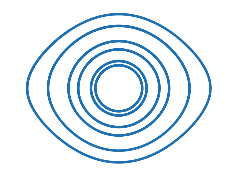

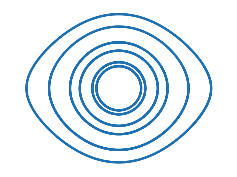

In [8]:
plt.figure(figsize=(4,3))
plt.plot(z_sim[:,:,0].T, z_sim[:,:,1].T, linewidth=2, color='#2071B1')
plt.axis('equal')
plt.axis('off')
plt.xticks([])
plt.yticks([])

plt.figure(figsize=(4,3))
plt.plot(pendulum_sim[:,:,0].T, pendulum_sim[:,:,1].T, linewidth=2, color='#2071B1')
plt.axis('equal')
plt.axis('off')
plt.xticks([])
plt.yticks([])

<ipython-input-9-4fd85e9b5649>:5: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(test_set_results['z'][ic_idx*t.size:(ic_idx+1)*t.size,0], 'k', color='#888888', linewidth=2)


(-49.95, 1048.95, -1.8604933500289917, 1.8560659170150757)

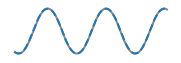

In [9]:
ic_idx = 1

plt.figure(figsize=(3,2))
plt.subplot(2,1,1)
plt.plot(test_set_results['z'][ic_idx*t.size:(ic_idx+1)*t.size,0], 'k', color='#888888', linewidth=2)
plt.plot(z_sim[ic_idx,:,0], '--', linewidth=2)
plt.xticks([])
plt.yticks([])
plt.axis('off')

## Test set analysis - in distribution

In [10]:
with open('../../test_data_max_variance.pkl', 'rb') as file:
    test_data = pickle.load(file)

In [11]:
test_data['x'].shape

(25000, 2601)

In [12]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver.restore(sess, data_path + save_name)
    test_dictionary = create_feed_dictionary(test_data, params)
    tf_results = sess.run(tensorflow_run_tuple, feed_dict=test_dictionary)

test_set_results = {}
for i,key in enumerate(autoencoder_network.keys()):
    test_set_results[key] = tf_results[i]

INFO:tensorflow:Restoring parameters from ../../sindy_models/original/model1


In [13]:
test_set_results.keys()

dict_keys(['coefficient_mask', 'x', 'dx', 'z', 'dz', 'x_decode', 'dx_decode', 'encoder_weights', 'encoder_biases', 'decoder_weights', 'decoder_biases', 'Theta', 'sindy_coefficients', 'ddz', 'ddz_predict', 'ddx', 'ddx_decode'])

In [14]:
test_set_results['x_decode'].shape

(25000, 2601)

# Unexplained Variance

In [15]:
decoder_x_error = np.mean((test_data['x'] - test_set_results['x_decode'])**2)/np.var(test_data['x'])
decoder_ddx_error = np.mean((test_data['ddx'] - test_set_results['ddx_decode'])**2)/np.var(test_data['ddx'])
sindy_ddz_error = np.mean((test_set_results['ddz'] - test_set_results['ddz_predict'])**2)/np.var(test_set_results['ddz'])

print(f'Decoder relative error: {decoder_x_error:.2e}')
print(f'Decoder relative SINDy error: {decoder_ddx_error:.2e}')
print(f'SINDy reltive error, z: {sindy_ddz_error:.2e}')

Decoder relative error: 1.05e-04
Decoder relative SINDy error: 2.00e-04
SINDy reltive error, z: 4.33e-03


In [17]:
# (Reference: 4.3)

# Original Notebook:
# Decoder relative error: 0.000330
# Decoder relative SINDy error: 0.000377
# SINDy reltive error, z: 0.021143

# Authors Errors

In [18]:
# Verified Results with 10 random initial conditions 

# 1
# Decoder relative error: 0.000042
# Decoder relative SINDy error: 0.000110
# SINDy reltive error, z: 0.002155

# 2
# Decoder relative error: 0.000059
# Decoder relative SINDy error: 0.000206
# SINDy reltive error, z: 0.003467

# 3
# Decoder relative error: 0.000333
# Decoder relative SINDy error: 0.000408
# SINDy reltive error, z: 0.017899

# 4
# Decoder relative error: 0.000074
# Decoder relative SINDy error: 0.000203
# SINDy reltive error, z: 0.004032

# 5
# Decoder relative error: 0.000048
# Decoder relative SINDy error: 0.000124
# SINDy reltive error, z: 0.002343

# MEAN +- STD
# Decoder relative error: (0.1112 +- 0.1114) * 10^-3
# Decoder relative SINDy error: (0.2102 +- 0.10645) * 10^-3
# SINDy reltive error, z: (5.9792 +- 6.000513) * 10^-3

In [19]:
# Verified Results with 50 random initial conditions 

# 1 
# Decoder relative error: 0.000116
# Decoder relative SINDy error: 0.000202
# SINDy reltive error, z: 0.005587

# 2
# Decoder relative error: 0.000150
# Decoder relative SINDy error: 0.000260
# SINDy reltive error, z: 0.006555

# 3
# Decoder relative error: 0.000062
# Decoder relative SINDy error: 0.000155
# SINDy reltive error, z: 0.002990

# 4
# Decoder relative error: 0.000133
# Decoder relative SINDy error: 0.000202
# SINDy reltive error, z: 0.004907

# 5
# Decoder relative error: 0.000099
# Decoder relative SINDy error: 0.000195
# SINDy reltive error, z: 0.005983

# MEAN +- STD
# Decoder relative error: (0.1119 +- 0.03023) * 10^-3
# Decoder relative SINDy error: (0.2028 +- 0.03352) * 10^-3
# SINDy reltive error, z: (5.2044 +- 1.2303) * 10^-3

In [20]:
import pandas as pd
from coefficient_names import sindy_library_tf_order2

In [21]:
coefficient_names = sindy_library_tf_order2(['z1', 'z2'], ['dz1', 'dz2'], params['latent_dim'], params['poly_order'], include_sine=True)
coefficient_names

['1',
 'z1',
 'z2',
 'z1*z1',
 'z1*z2',
 'z2*z2',
 'z1*z1*z1',
 'z1*z1*z2',
 'z1*z2*z2',
 'z2*z2*z2',
 'sin(z1)',
 'sin(z2)']

In [22]:
test_set_results['sindy_coefficients']

array([[ 1.64699304e-05],
       [ 8.80693460e-06],
       [ 1.47014525e-05],
       [ 2.98893883e-06],
       [ 6.24046061e-06],
       [ 3.05821195e-05],
       [-3.78970572e-06],
       [-7.70796942e-06],
       [ 1.90011851e-05],
       [ 4.26557708e-05],
       [-9.90657449e-01],
       [-8.39746372e-06]], dtype=float32)

In [23]:
masked_coefficients = np.array([[(c[0].round(3) if m else '-') for c, m in zip(coefficients, mask)] for coefficients, mask in zip([test_set_results['sindy_coefficients']], [params['coefficient_mask']])]).reshape(1, 12)#.round(3)

In [24]:
pd.DataFrame(masked_coefficients, columns=coefficient_names)

1 z1 z2 z1*z1 z1*z2 z2*z2 z1*z1*z1 z1*z1*z2 z1*z2*z2 z2*z2*z2 sin(z1)  \
0  -  -  -     -     -     -        -        -        -        -  -0.991   

  sin(z2)  
0       -